# SentimentAnalysis

## 학습목표

* 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다.
* RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법을 이해한다.
* 1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다.
* IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성 분류 실습을 진행한다.

## 감정분석

* 감정, 감성, 태도, 입장 등을 분석
1. 데이터 수집
2. 주관성 탐지
3. 주관성의 극성에 따른 분류
* 기계학습 기반과 감성 사전 기반으로 나뉨
  - 기계학습 : 존재하는 패턴을 학습, 긍정/부정으로 분류된 학습용 데이터가 필요
  - 감성사전 : 감성어와 극성범주에 따라 계산

## 텍스트 데이터의 특징

### 텍스트를 숫자로 표현하기

* 문장을 단어로 나눈 뒤, 각각의 단어를 딕셔너리에 넣습니다.
* 딕셔너리의 형태는 최종적으로 {텍스트:인덱스} 구조로 나와야합니다 
* 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
* BOS(문장의 시작 지점), PAD(패딩용 단어), UNK(사전에 없는 단어)는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 

In [1]:
# 하나의 문장
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']
# split()을 통해 공백 단위로 끊어서 단어로 이루어진 리스트를 만듭니다.
word_list = 'i feel hungry'.split()
print(word_list)
# dict 하나 만들기
index_to_word={} 
# 숫자 - '단어' 형태로 dict에 넣기
index_to_word[0]='<PAD>'
index_to_word[1]='<BOS>'
index_to_word[2]='<UNK>'
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

['i', 'feel', 'hungry']
{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


* 기존 {인덱스:텍스트} 구조에서 {텍스트:인덱스} 구조로 만듭니다.
* 즉 문자를 넣으면 숫자가 나오게 바꿉니다.
* feel을 넣으면 4가 나옵니다.

In [2]:
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)
print(word_to_index['feel'])

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}
4


* 가지고 있던 텍스트 데이터를 숫자로 만들어봅시다.
* sentence를 잘라서 보되 첫번째 값은 BOS로 두고 모르는 단어가 나오면 UNK를 뽑습니다.

In [3]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


* 여러개의 문장을 바꿔봅시다.

In [4]:
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


물론 숫자를 다시 텍스트로 되돌릴 수도 있습니다.

In [5]:
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


여러개의 숫자 모음을 문장들로 바꿀 수도 있겠네요.

In [6]:
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


### Embedding 레이어의 등장

* 숫자로 변환 시킬 수 있었지만 이는 단순히 임의로 부여된 숫자와 같다.
* 우리가 하고싶은 것은 단어와 그 단어의 의미를 나타내는 벡터를 잇는 것이다.
* 단어의 의미를 나타내는 벡터를 훈련 가능한 파라미터로 놓고 이를 딥러닝을 통해 학습.
* 딥러닝 프레임워크들은 이러한 의미 파라미터를 구현한 Embedding layer를 제공

* Embedding layer
- 자연어 처리(NLP)에서 Embedding은 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자형태인 vector로 바꾼 결과 혹은 그 일련의 과정 전체를 의미
- 가장 간단한 형태의 임베딩은 단어의 빈도를 그대로 벡터로 사용하는 것이다.
- 단어나 문장 사이의 코사인 유사도가 가장 높은 단어를 구하는 등의 계산
- 단어들 사이의 의미/문법적 정보 도출 벡터 간 연산으로 단어 사이 문법적 관계 도출, 전이 학습(transfer learning)
- 임베딩은 다른 딥러닝 모델의 입력값으로 자주 쓰이고, 품질 좋은 임베딩을 쓸수록 모델의 성능이 좋아집니다.
- Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 합니다.
- tf.keras.preprocessing.sequence.pad_sequences라는 편리한 함수를 통해 문장 벡터 뒤에 패딩(<PAD>)을 추가하여 길이를 일정하게 맞춰주는 기능을 제공합니다.

In [7]:
import numpy as np
import tensorflow as tf
import os

vocab_size = len(word_to_index)
print('vocab_size =', vocab_size)
word_vector_dim = 4 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype=object)
print('pre_raw_inputs type = ', type(raw_inputs))
print('pre_raw_inputs.shape = ', raw_inputs.shape)
print('pre_raw_inputs :\n', raw_inputs)

raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs, value=word_to_index['<PAD>'], padding='post', maxlen=5)
print('post_raw_inputs.shape type =', type(raw_inputs))
print('post_raw_inputs.shape =', raw_inputs.shape)
print('post_raw_inputs :\n', raw_inputs)

vocab_size = 10
pre_raw_inputs type =  <class 'numpy.ndarray'>
pre_raw_inputs.shape =  (3,)
pre_raw_inputs :
 [list([1, 3, 4, 5]) list([1, 3, 6, 7]) list([1, 8, 3, 4, 9])]
post_raw_inputs.shape type = <class 'numpy.ndarray'>
post_raw_inputs.shape = (3, 5)
post_raw_inputs :
 [[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]


* vocab_size : 딕셔너리에 포함된 단어의 개수
* word_vector_dim : 단어 벡터의 차원
* 변경전에는 각 문장을 요소로 가지는 1차원
* 변경 후에는 최대 길이를 열로 가지고 문장 갯수를 열로 가지는 행렬로 바꿔줌(모자란 부분은 0으로 채워줌)
* [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
  - input_dim : 입력의 차원 : 단어사전의 길이
  - output_dim : 임베딩 깊이의 차원(벡터의 차원)
  - mask_zero : True시 0인 값은 넘겨준다.

In [8]:
output = embedding(raw_inputs)
print('output :\n',output)

output :
 tf.Tensor(
[[[-3.48314643e-05 -4.97696288e-02 -3.59109789e-03 -3.47419605e-02]
  [-2.05336809e-02  8.33474472e-03  2.18068995e-02 -4.02070582e-04]
  [-3.20917964e-02  1.76998228e-03  2.35836767e-02 -7.13056326e-03]
  [-3.73025760e-02  1.91163458e-02  1.32448785e-02 -2.79178154e-02]
  [ 6.75462186e-04  6.17422909e-03  2.46769674e-02 -1.22826211e-02]]

 [[-3.48314643e-05 -4.97696288e-02 -3.59109789e-03 -3.47419605e-02]
  [-2.05336809e-02  8.33474472e-03  2.18068995e-02 -4.02070582e-04]
  [-4.60817330e-02 -1.52324662e-02  6.86053187e-03  4.77217920e-02]
  [-4.20853496e-02  2.34999992e-02 -2.15549469e-02  3.66985090e-02]
  [ 6.75462186e-04  6.17422909e-03  2.46769674e-02 -1.22826211e-02]]

 [[-3.48314643e-05 -4.97696288e-02 -3.59109789e-03 -3.47419605e-02]
  [-3.52276936e-02  3.12785991e-02  2.62771584e-02  4.56818193e-03]
  [-2.05336809e-02  8.33474472e-03  2.18068995e-02 -4.02070582e-04]
  [-3.20917964e-02  1.76998228e-03  2.35836767e-02 -7.13056326e-03]
  [ 1.34220608e-02 -3.7

2022-08-12 17:05:37.230578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-12 17:05:37.684171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


## RNN

Language Model  
<img src="LanguageModel.png" width = "30%" height = "30%">

* 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine
* stateful : 이전 시점에 어떤 선택을 하였는지 기억
* stateless : 이전 시점에 어떤 선택을 하였는지 기억 못함

LSTM  
<img src="LSTM.png" width = "70%" height = "70%">  
LSTM Gradient  
<img src="LSTMGradient.png" width = "70%" height = "70%">  
[Tensorflow 여러 Layer에 대한 간단한 설명](https://goatlab.tistory.com/85)

In [9]:
vocab_size = 10
word_vector_dim = 4

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 4)           40        
                                                                 
 lstm (LSTM)                 (None, 8)                 416       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


model
1. sequential 모델 생성
2. Embedding layer 생성
3. LSTM 레이어 생성, arg는 LSTM state 벡터의 차원수
4. 최종 출력은 긍정/부정을 나타내는 1차원 입니다.

## CNN

[1D Convolutional Neural Networks](https://www.youtube.com/watch?v=nMkqWxMjWzg&t=1008s)  
[CNN 기초 설명 영상(한국어)](https://www.youtube.com/watch?v=Fm9x770eSF0)

### Convolution

<img src="Convolution.png" width = "70%" height = "70%">  

* 2개의 신호가 있다.
* 신호가 이산적인 데이터면 합한다.
* 신호가 연속적인 데이터면 곱한다음 적분한다.
* 2개의 신호 중 하나를 reverse하고 shift 하면서 진행
* 위에서 reverse 했다면 convolution
* reverse 하지 않았다면 cross correlation

### 1D Convolution

<img src="1DConvolution.png" width = "50%" height = "50%">
<img src="1DConvolution-2.png" width = "50%" height = "50%">

* 사실상 cross-correlation
* Input : 입력되는 값
* Kernel(Filter) : Mask의 개념
* Output : 계산되어 나오는 값, 길이는 Input의 길이 - Kerenl의 길이 + 1

### CNN

* 이전에 이미지 데이터를 CNN에 사용해보았다.
* 이미지는 sequence data가 아니다.
* 1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝
* 발견되는 특징을 추출해서 문장을 분류

In [10]:
vocab_size = 10 
word_vector_dim = 4

def CNN1D(vocab_size, word_vector_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(5))
    model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model

CNN1D(vocab_size, word_vector_dim).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 4)           40        
                                                                 
 conv1d (Conv1D)             (None, None, 16)          464       
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

* GlobalMaxPooling1D() : 전체 문장 중 가장 중요한 단어만 feature로 추출, 그것으로 긍정/부정을 평가
* [추가 내용 참고](https://wikidocs.net/80437)

In [11]:
vocab_size = 10
word_vector_dim = 4

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 4)           40        
                                                                 
 global_max_pooling1d_1 (Glo  (None, 4)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 40        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## IMDB 영화리뷰 감성분석

### IMDB Dataset Analysis

데이터셋 다운로드

In [12]:
imdb = tf.keras.datasets.imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

훈련 샘플 개수: 25000, 테스트 개수: 25000


1개 보기

In [13]:
print(x_train[0])
print('\n라벨: ', y_train[0])

print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

print('type(x_train): ', type(x_train))
print('type(y_train): ', type(y_train))
print('type(x_train[0]): ', type(x_train[0]))
print('type(y_train[0]): ', type(y_train[0]))
print('set(y_train) :', set(y_train))


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189
type(x_train):

* 이미 텍스트가 encode 되어 숫자로 나옵니다.
* x_train을 문장들을 요소로 가지고, y_train은 0 또는 1로 긍정/부정을 나타냅니다.
* IMDB는 encode에 사용된 단어사전도 함께 제공합니다.

In [14]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


* word_to_index, index_to_word를 추가 보정해줘야합니다.
* Tensorflow tutorial guide를 반영하였습니다.
* word_to_index 는 단어 출현 빈도 기준으로 내림차수 정렬되어 있습니다.

In [15]:
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])
print(word_to_index['the'])
print(index_to_word[4])

<BOS>
4
the


* 실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.
* 3칸 뒤로 설정해서 the의 숫자값이 4로 나옵니다.
* 처음 몇 개 인덱스는 사전에 정의되어 있습니다

encode된 데이터가 정상적으로 decode 되는지 확인해봅시다.

In [16]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

* pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일
* maxlen 설정이 중요하다.

In [17]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [18]:
len(total_data_text)

50000

* total_data_text : x_train + x_test 를 합친 list
* num_token : 문장의 길이를 요소로 가지는 list
* ndarray로 만든뒤 평균, 최대, 표준편차를 구합니다.
* maxlen 을 평균 + 2 * 표준편차라고 둡니다.

* padding 방법은 post와 pre로 나눠집니다.
* RNN은 순차적으로 처리되니 마지막 입력이 최종 state에 많은 영향을 끼치므로 마지막 입력이 padding 되는건 비효율적입니다.
* 따라서 pre가 훨씬 더 유리합니다.

In [19]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


### DeepLearning model train

In [20]:
vocab_size = 10000
# word_vector_dim = 16
word_vector_dim = 32

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 328,593
Trainable params: 328,593
Non-trainable params: 0
_________________________________________________________________


* 훈련 전에 훈련 Data 25000 중 10000 건을 분리하여 validation set으로 사용합니다.

In [21]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=250

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0)

2022-08-12 17:05:44.435747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


평가

In [23]:
results = model.evaluate(x_test,  y_test, verbose=0)

print(results)

[0.6274763941764832, 0.8385999798774719]


* 모델 fit 과정의 train/validation loss,accuray 등이 epoch 마다 history 변수에 저장되어 있습니다.
* 이를 활용해 시각화합니다.

In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, epochs + 1)

In [26]:
print(len(acc), len(val_acc), len(loss), len(val_loss))

250 250 250 250


/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


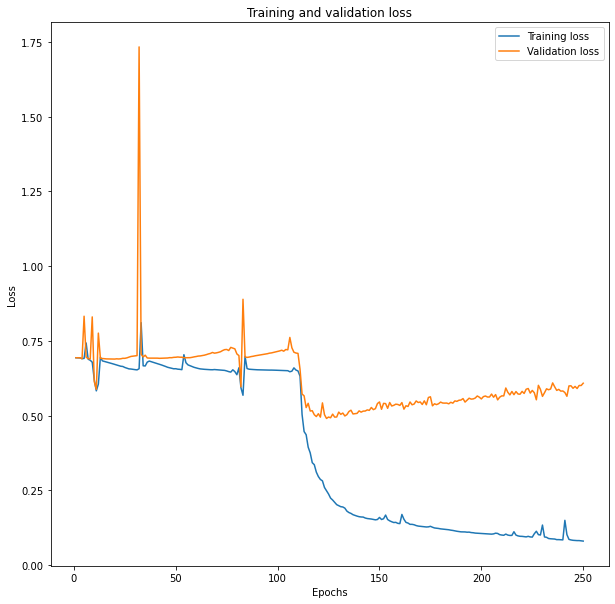

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# # "bo"는 "파란색 점"입니다
# plt.plot(epochs, loss, 'bo', label='Training loss')
# # b는 "파란 실선"입니다
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.figure(figsize= (10,10))
sns.lineplot(epochs, loss, label = 'Training loss')
sns.lineplot(epochs, val_loss, label = 'Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aiffel/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


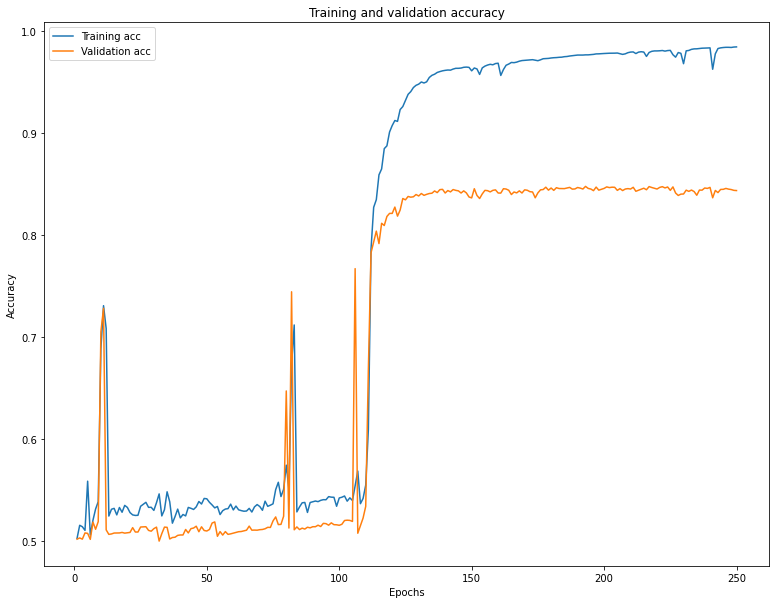

In [28]:
# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')0
plt.figure(figsize= (13,10))
sns.lineplot(epochs, acc, label = 'Training acc')
sns.lineplot(epochs, val_acc, label = 'Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Word2Vec

In [29]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


* 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
* 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 

In [30]:
# word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
word2vec_file_path = 'data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

* gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-3.9892145e-02,  2.0107888e-02,  1.2722430e-01,  6.1304118e-02,
       -3.1523157e-02,  2.5139205e-02, -5.0652195e-03, -4.6063732e-02,
        2.4697376e-02,  1.0284799e-01, -9.0058216e-05,  6.0891885e-02,
       -4.0985797e-02,  9.0144478e-02, -9.3769521e-02,  1.9588700e-02,
        6.4451471e-02,  2.9152998e-01, -1.3984844e-01, -1.4015239e-01,
       -3.6348309e-02, -9.0904564e-02, -1.1320929e-02,  3.9695524e-02,
       -2.6846835e-03,  6.4533971e-02,  7.9164214e-02,  1.2263695e-01,
        1.1420945e-02, -4.1285668e-02, -5.9725929e-02,  4.3143155e-03],
      dtype=float32)

In [32]:
word_vectors.similar_by_word("love")

[('emotional', 0.928955614566803),
 ('persona', 0.9279842376708984),
 ('guts', 0.925996720790863),
 ('puts', 0.9246079921722412),
 ('stands', 0.9232618808746338),
 ('breathless', 0.9221992492675781),
 ('pictures', 0.9218646287918091),
 ('blooded', 0.9209948778152466),
 ('buddy', 0.9190439581871033),
 ('underwater', 0.9174160361289978)]